# Calculating (constant) Arrival Rate from LOS - LogNormal
### Given: Length of stay (LOS) per month, per age group, per hospitals, per CTAS, per PT and Number of ED visits per age group, per hospitals.

1. The arrival rate should be non-stationary (NSPP), most probably. 
2. Using the Little's law will generate arrival rate (λ) for a stationary process.
3. Using LOS to generate Arrival and inter-arrival rates will e stationary as well.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, lognorm
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
%matplotlib inline

## Predicting the distribution of LOS from 50th and 90th percentile values

Predicted distribution of LOS values from given 50th and 90th percentile is a Log-normal distribution. 

1. Assumption for log-normal is made.
2. Random LOS values are generated using 'lognorm.rvs' method in the scipy library.
3. KS test is used to compare the empirical CDF (from the samples generated) with the expected CFD (the log-normal that we assumed)

In [2]:
xls = pd.ExcelFile("data/provisional-emergency-department-visits-apr-sep-2022-provisional-data-tables-en.xlsx")
xls.sheet_names

['ED Visits, 2022–2023',
 'Notes to readers',
 'Table of contents',
 '1 ED visits, LOS',
 '2 ED visits, month, age and sex',
 '3 Top 10 main problems']

In [3]:
df = pd.read_excel("data/provisional-emergency-department-visits-apr-sep-2022-provisional-data-tables-en.xlsx", xls.sheet_names[3])
df.head(5)

,"Screen reader users: There is 1 table on this tab called Table 1: Number of ED visits and length of stay by Canadian Triage and Acuity Scale (CTAS) levels and admitted cases, participating provinces/territories, NACRS, April 2022 to September 2022. It begins at cell A5 and ends at cell K15. The notes begin in cell A16, coverage information begins in cell A24 and the source begins in cell A26. A link back to the table of contents is in cell A2.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,Back to the Table of contents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Table 1 Number of ED visits and length of sta...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,ED volumes,NaN,NaN,NaN,"Median \n(50% spent less, in hours)",NaN,NaN,"90th percentile \n(90% spent less, in hours)",NaN,NaN
3,Province/territory*,\nTotal\nED volumes,CTAS levels I–III (discharged)†\nED volumes,CTAS levels IV–V (discharged)‡\nED volumes,\nAdmitted§\nED volumes,CTAS levels I–III (discharged)†\nMedian (50% s...,CTAS levels IV–V (discharged)‡\nMedian (50% sp...,"\nAdmitted§\nMedian (50% spent less, in hours)",CTAS levels I–III (discharged)†\n90th percenti...,CTAS levels IV–V (discharged)‡\n90th percentil...,"\nAdmitted§\n90th percentile (90% spent less, ..."
4,P.E.I.**,34322,13647,8839,3590,4.7,5,19.5,10.3,10.8,81.2


In [4]:
df = df.rename(columns = {"Screen reader users: There is 1 table on this tab called Table 1: Number of ED visits and length of stay by Canadian Triage and Acuity Scale (CTAS) levels and admitted cases, participating provinces/territories, NACRS, April 2022 to September 2022. It begins at cell A5 and ends at cell K15. The notes begin in cell A16, coverage information begins in cell A24 and the source begins in cell A26. A link back to the table of contents is in cell A2.": "Province/Territory",
                         "Unnamed: 1": "Total ED volume",
                         "Unnamed: 2": "ED volume CTAS I-III",
                         "Unnamed: 3": "ED volume CTAS IV-V",
                         "Unnamed: 4": "ED volume Admitted",
                         "Unnamed: 5": "50th percentile LOS - CTAS I-III",
                         "Unnamed: 6": "50th percentile LOS - CTAS IV-V",
                         "Unnamed: 7": "50th percentile LOS - Admitted",
                         "Unnamed: 8": "90th percentile LOS - CTAS I-III",
                         "Unnamed: 9": "90th percentile LOS - CTAS IV-V",
                         "Unnamed: 10": "90th percentile LOS - Admitted"})

In [5]:
df = df.fillna('False')
df.head(5)

,Province/Territory,Total ED volume,ED volume CTAS I-III,ED volume CTAS IV-V,ED volume Admitted,50th percentile LOS - CTAS I-III,50th percentile LOS - CTAS IV-V,50th percentile LOS - Admitted,90th percentile LOS - CTAS I-III,90th percentile LOS - CTAS IV-V,90th percentile LOS - Admitted
0,Back to the Table of contents,False,False,False,False,False,False,False,False,False,False
1,Table 1 Number of ED visits and length of sta...,False,False,False,False,False,False,False,False,False,False
2,False,ED volumes,False,False,False,"Median \n(50% spent less, in hours)",False,False,"90th percentile \n(90% spent less, in hours)",False,False
3,Province/territory*,\nTotal\nED volumes,CTAS levels I–III (discharged)†\nED volumes,CTAS levels IV–V (discharged)‡\nED volumes,\nAdmitted§\nED volumes,CTAS levels I–III (discharged)†\nMedian (50% s...,CTAS levels IV–V (discharged)‡\nMedian (50% sp...,"\nAdmitted§\nMedian (50% spent less, in hours)",CTAS levels I–III (discharged)†\n90th percenti...,CTAS levels IV–V (discharged)‡\n90th percentil...,"\nAdmitted§\n90th percentile (90% spent less, ..."
4,P.E.I.**,34322,13647,8839,3590,4.7,5,19.5,10.3,10.8,81.2


In [6]:
bc = df[df["Province/Territory"].str.match(r"B.C.(.*?)")]
# df["Province/Territory"].str.match(r"B.C.(.*?)")

# Claculations for CTAS I - III only.
mean_50 = float(bc["50th percentile LOS - CTAS I-III"])
mean_90 = float(bc["90th percentile LOS - CTAS I-III"])
ed_visits = int(bc["ED volume CTAS I-III"])

print(mean_50, mean_90, ed_visits)
bc

3.9 8.0 430213


,Province/Territory,Total ED volume,ED volume CTAS I-III,ED volume CTAS IV-V,ED volume Admitted,50th percentile LOS - CTAS I-III,50th percentile LOS - CTAS IV-V,50th percentile LOS - Admitted,90th percentile LOS - CTAS I-III,90th percentile LOS - CTAS IV-V,90th percentile LOS - Admitted
11,B.C.**,870924,430213,266125,105106,3.9,2.7,17.8,8,5.6,52.8


Referring the following link:
https://math.stackexchange.com/questions/2132005/percentile-of-lognormal-and-its-first-moments

Estimation for mean and variance can be made from the given 50th and 90th percentiles for a log-normal distribution

In [19]:
# estimated_mean = np.log(mean_50)
mu = np.log(mean_50)
sigma = estimated_std = (np.log(mean_90) - np.log(mean_50))/ lognorm.ppf(0.9, s=1)

estimates_mean = np.exp(mu + (sigma**2)/2)
estimated_variance = (np.exp(sigma**2) - 1) * (np.exp(2*mu + sigma**2))

# Here s is the shape parameter of the log-normal distribution
# s = 1 means that we assume the data to be standard log-normal distribution

print(estimated_mean, estimated_std, estimated_variance)

1.7202090474077183 0.1994503653720124 0.6423062764946311


## Generation of LOS random samples from log-normal distribution

In [20]:
# Generate random samples/variables
n_samples = ed_visits
samples = lognorm.rvs(s=estimated_std, scale=np.exp(estimated_mean), size=n_samples)
# print(samples)

In [21]:
# Using the random samples generated, verify the estimated values.
sample_mean = np.mean(samples)
# prob_long_stay = 1 - lognorm.cdf(8, s=estimated_std, scale=np.exp(estimated_mean))
print(sample_mean, np.log(sample_mean))

5.698154314296149 1.740142317895057


In [22]:
# Estimate the lognorm parameters by fitting lognorm on sample data
s, loc, scale = lognorm.fit(samples)
print(s, loc, scale)

0.19990731022118569 0.012306239879557075 5.57336469715105


In [23]:
print(s, loc, scale)
print(estimated_std, 0, np.exp(estimated_mean))

0.19990731022118569 0.012306239879557075 5.57336469715105
0.1994503653720124 0 5.585696017507576


## Q-Q Plot

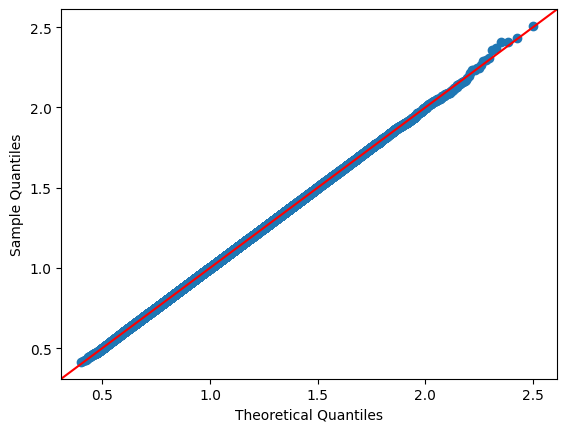

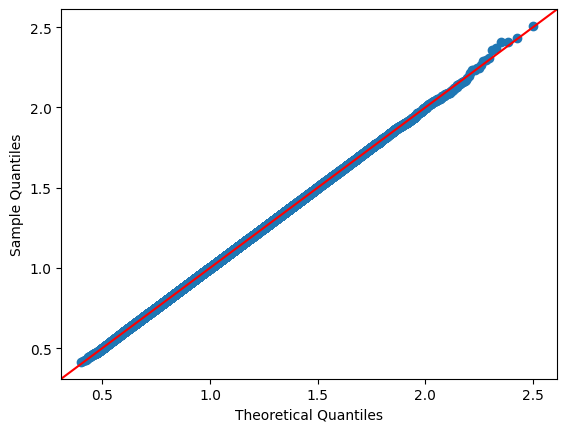

In [24]:
sm.qqplot(data=samples, dist=lognorm, fit=True, line='45')

### Goodness-of-fit test

Can perform either:
1. Chi-square test (Can use this here since the sample size is huge)
2. KS test (preferred when sample size is less)

In [25]:
# Check the samples using KS test
# Lower statistic value and higher pvalue (>=0.05) are better indicating that the distrbution is a match.
result = kstest(rvs=samples, cdf=lognorm.cdf, args=(estimated_std, 0, np.exp(estimated_mean)))
print(result)

KstestResult(statistic=0.0011247007835372136, pvalue=0.6474733574210032, statistic_location=5.277040388065932, statistic_sign=-1)


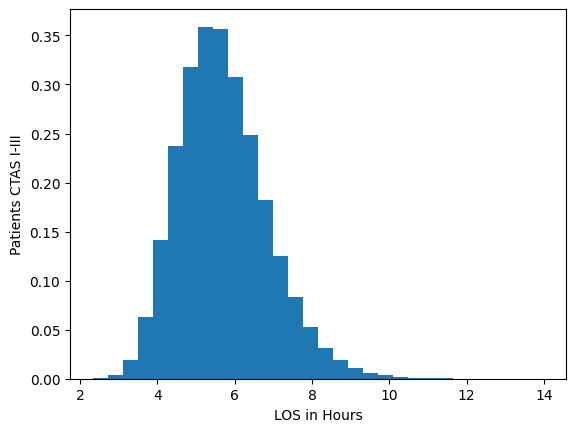

In [26]:
# Plotting the samples
x = samples

plt.hist(x, density=True, bins=30)  # bins = 'auto'
plt.ylabel('Patients CTAS I-III')
plt.xlabel('LOS in Hours');

# Standard log-norm distribution
# lognorm_dist = lognorm(s=1, loc=3.25)
# y = np.linspace(0, 10, ed_visits)
# plt.plot(y, lognorm_dist.pdf(y))
# plt.show()

### Therefore, LOS follows a log-normal distribution

Now, to find the arrival rate, 

In [27]:
# ED arrivals per day - arrival rate!
ed_visits_per_month = ed_visits/6
ed_visits_per_day = ed_visits_per_month/30
ed_visits_per_hour = ed_visits_per_day/24
ed_visits_per_minute = ed_visits_per_hour/60
print(ed_visits, ed_visits_per_month, ed_visits_per_day, ed_visits_per_hour, ed_visits_per_minute)

430213 71702.16666666667 2390.0722222222225 99.5863425925926 1.65977237654321


In [28]:
# Mean inter arrival time in minutes per patient
mean_inter_arrival_time = 60/(ed_visits_per_hour * estimated_mean)
print(mean_inter_arrival_time)

# or shall I use sample mean?
mean_inter_arrival_time_2 = 60/(ed_visits_per_hour * np.log(sample_mean))
print(mean_inter_arrival_time_2)

0.35024362576454465
0.3462315970603201


In [29]:
# Arrival rate in patients per minutes
arrival_rate = 1/mean_inter_arrival_time
print(arrival_rate)

arrival_rate_2 = 1/mean_inter_arrival_time_2
print(arrival_rate_2)

2.8551554587670402
2.8882401504960886


In [ ]:
# arrival_rate_3 = 1/ed_visits_per_minute
# print(arrival_rate_3)